# Autonomous Perception Robustness Testing Framework (APRTF)
### Development Journal

We show that our general framework can be used on the [NuScenes](https://www.nuscenes.org/) dataset using a multi-stage analysis proposed in ["Perception robustness testing at different levels of generality"](https://www.journalfieldrobotics.org/FR/Papers_files/10_Pezzementi.pdf).

In [1]:
import os

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

from PIL import Image
import torch
import torchvision.transforms as T

from nuscenes.utils.geometry_utils import view_points
from nuscenes import NuScenes
data_dir = './data/sets/nuscenes'
nusc = NuScenes(version='v1.0-mini', dataroot=data_dir, verbose=True)

# torchvision reference code
from aprtf.dataset import PedestrianDetectionDataset2, get_transform
from aprtf.references import utils, engine
from aprtf.visuals import visualize_results

print("All packages imported!")

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.457 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
All packages imported!


/home/jonathan/miniconda3/envs/tas/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jonathan/miniconda3/envs/tas/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit 

## I. Pedestrian Detection

### Data and Labels

Time-ordered iterator of images and bounding boxes.

In [2]:
def box2bb(box, cam_intrinsic):
    corners = view_points(box.corners(), view=cam_intrinsic, normalize=True)[:2, :]
    bb = np.concatenate([np.min(corners, axis=1), np.max(corners, axis=1)])
    return bb

In [3]:
category = 'pedestrian'
sensor = 'CAM_FRONT'
visibility_threshold = 2

scene = nusc.scene[0]

scene_data_fps = []
scene_data_anns = []
scene_data_bbs = []

next_sample_token = scene['first_sample_token']
while next_sample_token:
    sample = nusc.get('sample', next_sample_token)
    sample_data = nusc.get('sample_data', sample['data'][sensor])

    # image filepaths
    sample_data_fp = os.path.join(data_dir,sample_data['filename'])
    scene_data_fps.append(sample_data_fp)

    # bounding boxes
    sample_data_bbs = []
    sample_data_anns = []
    for ann in sample['anns']:
        _, box, cam_intrinsic = nusc.get_sample_data(sample['data'][sensor], selected_anntokens=[ann])
        if len(box) > 1:
            raise ValueError('more than one annotation')

        visibility_token = nusc.get('sample_annotation', ann)['visibility_token']
        visibility = int(visibility_token)
        if (len(box) == 1) and (category in box[0].name) and (visibility >= visibility_threshold):
            bb = box2bb(box[0], cam_intrinsic)
            sample_data_bbs.append(bb)
            sample_data_anns.append(ann)
    scene_data_bbs.append(sample_data_bbs)
    scene_data_anns.append(sample_data_anns)
    
    next_sample_token = sample['next']

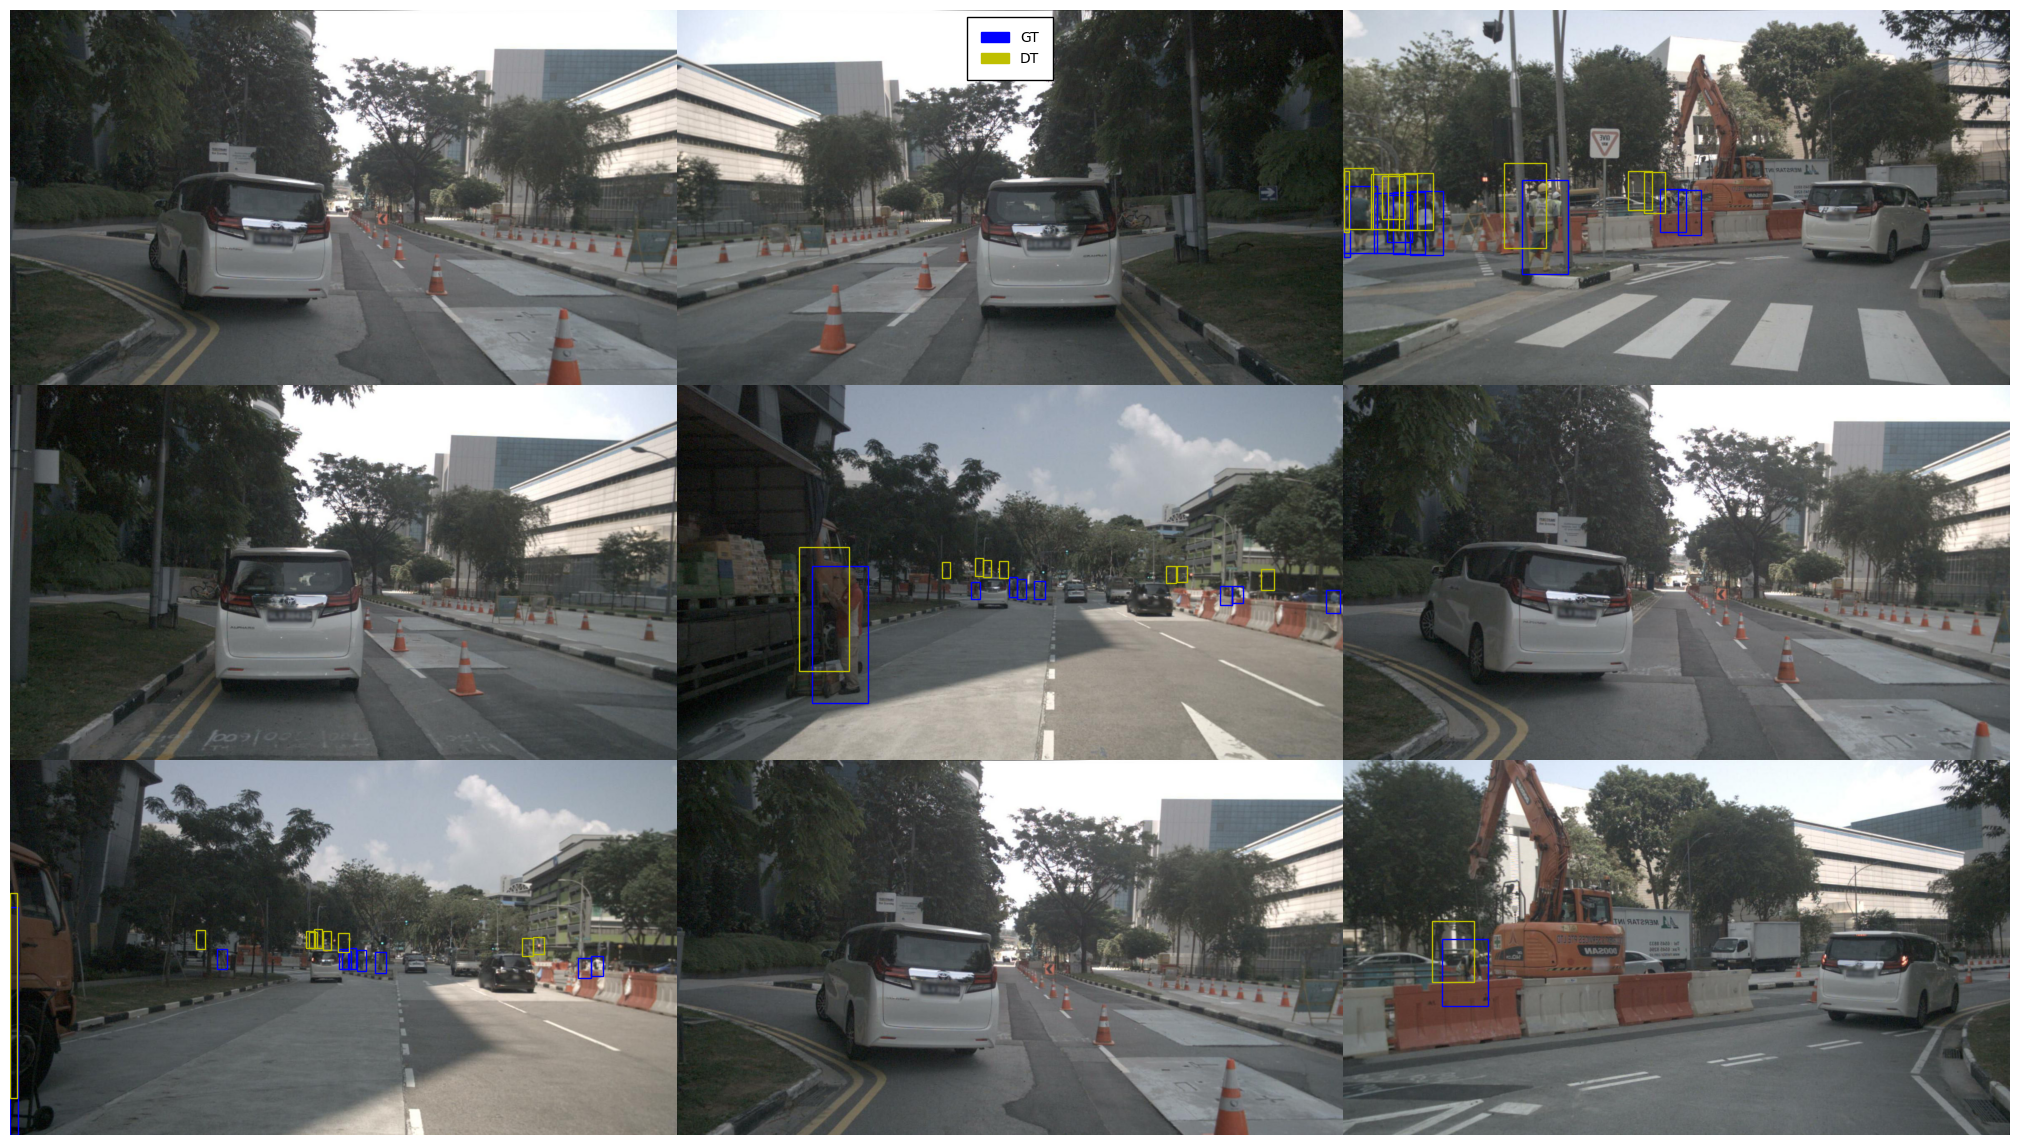

In [5]:
torch.manual_seed(45)
dataset = PedestrianDetectionDataset2(scene_data_fps, scene_data_bbs, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=1, shuffle=True, num_workers=1,
 collate_fn=utils.collate_fn)

images = []
gt_bbs = []
dt_bbs = [] 

for i in range(9):
    output_ims, targets = next(iter(data_loader))
    target = [{k: v for k, v in t.items()} for t in targets]

    image = T.ToPILImage()(output_ims[0])
    images.append(image)

    gt_bbs.append(target[0]['boxes'])
    dt_bbs.append(target[0]['boxes'] * 0.9)

visualize_results('output.png', images, gt_bbs, dt_bbs)

### Model

Takes in batch or single image, and outputs pedestrian bounding boxes.

In [5]:
from torchvision.models.detection import retinanet_resnet50_fpn_v2, fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

num_classes = 2  # 1 class (person) + background

retinanet = retinanet_resnet50_fpn_v2(weights='DEFAULT')        
# replace the pre-trained head with a new one
in_features = retinanet.head.classification_head.cls_logits.in_channels
num_anchors = retinanet.head.classification_head.num_anchors
retinanet.head.classification_head = RetinaNetClassificationHead(in_features, num_classes, num_anchors)

rcnn = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
# replace the pre-trained head with a new one
in_features = rcnn.roi_heads.box_predictor.cls_score.in_features
rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Training:

In [6]:
def generate_random_set_splits(dataset_len, train_frac=0.8, test_frac=0.1, seed=42):
    are_positive = (0 < train_frac) and (0 < test_frac)
    in_range = (train_frac + test_frac <= 1)
    if not (are_positive and in_range):
        raise ValueError("Dataset splits are impossible")
    
    rng = np.random.default_rng(seed)
    idxs = np.arange(dataset_len)
    rand_idxs = rng.permutation(idxs)
    
    train_threshold = int(train_frac* dataset_len)
    test_threshold = int((train_frac+test_frac) * dataset_len)
    train, validate, test = np.split(rand_idxs, [train_threshold, test_threshold])
    return train, validate, test

def generate_set_splits(dataset_len, train_frac=0.8, test_frac=0.1):
    are_positive = (0 < train_frac) and (0 < test_frac)
    in_range = (train_frac + test_frac <= 1)
    if not (are_positive and in_range):
        raise ValueError("Dataset splits are impossible")
    
    idxs = np.arange(dataset_len)
    train_threshold = int(train_frac* dataset_len)
    test_threshold = int((train_frac+test_frac) * dataset_len)
    train, validate, test = np.split(idxs, [train_threshold, test_threshold])
    return train, validate, test

In [13]:
def main(model):
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    # use our dataset and defined transformations
    dataset_train = PedestrianDetectionDataset2(scene_data_fps, scene_data_bbs, transforms=get_transform(train=True))
    dataset_val = PedestrianDetectionDataset2(scene_data_fps, scene_data_bbs, transforms=get_transform(train=False))
    dataset_test = PedestrianDetectionDataset2(scene_data_fps, scene_data_bbs, transforms=get_transform(train=False))
    
    train_idxs, val_idxs, test_idxs = generate_set_splits(len(scene_data_fps))

    # split the dataset in train, val and test set
    dataset_train = torch.utils.data.Subset(dataset_train, train_idxs)
    dataset_val = torch.utils.data.Subset(dataset_val, val_idxs)
    dataset_test = torch.utils.data.Subset(dataset_test, test_idxs)

    # define training and validation data loaders
    data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=1, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)
    
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        engine.train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
        # evaluate on the validation dataset
        engine.evaluate(model, data_loader_val, device=device)
        # update the learning rate
        lr_scheduler.step()
    # evaluation on test dataset
    engine.evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [16]:
torch.cuda.empty_cache()
main(rcnn)

Epoch: [0]  [ 0/31]  eta: 0:00:39  lr: 0.000172  loss: 0.0953 (0.0953)  loss_classifier: 0.0605 (0.0605)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0348 (0.0348)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 1.2611  data: 0.3404  max mem: 3299
Epoch: [0]  [10/31]  eta: 0:00:20  lr: 0.001837  loss: 0.4724 (0.3946)  loss_classifier: 0.1035 (0.0932)  loss_box_reg: 0.3018 (0.2609)  loss_objectness: 0.0275 (0.0249)  loss_rpn_box_reg: 0.0061 (0.0156)  time: 0.9541  data: 0.0350  max mem: 3299
Epoch: [0]  [20/31]  eta: 0:00:10  lr: 0.003502  loss: 0.4880 (0.4863)  loss_classifier: 0.1059 (0.1084)  loss_box_reg: 0.3215 (0.3007)  loss_objectness: 0.0275 (0.0298)  loss_rpn_box_reg: 0.0136 (0.0474)  time: 0.9254  data: 0.0050  max mem: 3299
Epoch: [0]  [30/31]  eta: 0:00:00  lr: 0.005000  loss: 0.5471 (0.4399)  loss_classifier: 0.1107 (0.0974)  loss_box_reg: 0.3215 (0.2790)  loss_objectness: 0.0263 (0.0276)  loss_rpn_box_reg: 0.0110 (0.0359)  time: 0.9298  data: 0.0054  max mem: 3299
Epoch: [

KeyboardInterrupt: 

### Metric

Recall and $FPR_A$.

In [ ]:
def recall():
    pass

def FPRa():
    pass